### In this notebook I use NLP techniques to spot potential multihosts in Bologna Airbnb host community, that's to say, multiple host ids that could be in fact just one host.

### For this purpose, I will use textual descriptions of the announces ("description", "space" and "summary" columns above all) into an Inside Airbnb dataset (http://insideairbnb.com/get-the-data.html by Murray Cox).

### Indeed, a lot of announces seem to have very similar or identical descriptions although they belong to different hosts. That means that apparently there's a copy-paste abuse among hosts that MAYBE belong to the same home structure. 

### But why one should ever do that? Why a big Airbnb commercial player is driven to create different host entities to handle his property? Look at that:

In [3]:
import pandas as pd

# Choose one of the zipped listing files on http://insideairbnb.com/get-the-data.html
# since it is richer in textual infos:

listings = pd.read_csv("listings_detailed/2_2020.csv")

set(listings[listings['calculated_host_listings_count'] > 10]\
    .sort_values('calculated_host_listings_count', ascending=False).host_name)

{'28',
 'Agostino',
 'Alessandro',
 'Andrea',
 'Arianna',
 'Bnbbologna',
 'Canguro Properties',
 'Flat In Italy',
 'Franco',
 'GetTheKey',
 'Halldis Apartments & Villas',
 'Luca',
 'Marco',
 'Michela Borghetto',
 'Rambaldo',
 'Realkasa',
 'Silvia',
 'Stefano',
 'The Place',
 'Vito',
 'Welcome To Bologna & Ferrara!'}

### This is the list of players with more than 10 announces on the platform: the commercial players, supposedly. As you can see, around the 50% of their names sounds definitely "human" and "italian", in spite of their commercial vocation. 

### Agostino, Franco, Silvia... They inspire confidence, intimacy, autenticity. Isn't strange? Would you let your uncle Mario represent your italian guesthouse in full? Apparently, you should! 

### Multihosts and commercial partners are a problem for Airbnb storytelling because they're faceless, and they're not consistent with the idea of a resident host, keen to show and explain his/her exotic city to guests. That's perhaps why the host identity tends to be humanized and parcellized on the platform.

### Now, let's have a look into this dataset:

In [4]:
listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42196,https://www.airbnb.com/rooms/42196,20200219034035,2020-02-19,50 sm Studio in the historic centre,NaN,Really cozy and typical bolognese 50 sm studio...,Really cozy and typical bolognese 50 sm studio...,none,NaN,...,t,f,flexible_new,f,f,5,2,3,0,1.52
1,46352,https://www.airbnb.com/rooms/46352,20200219034035,2020-02-19,A room in Pasolini's house,"Simple, cozy and silent room in a lived house ...",Please take two minutes of your time to read e...,"Simple, cozy and silent room in a lived house ...",none,In the very nearby you have Via Saragozza whic...,...,f,f,flexible_new,f,f,2,0,2,0,2.23
2,59697,https://www.airbnb.com/rooms/59697,20200219034035,2020-02-19,BOLOGNA CENTRE RELAX & COMFORT,"Situato nel centro storicocuore di Bologna, vi...",The apartment is located at the heart of Bolog...,The apartment is located at the heart of Bolog...,none,NaN,...,f,f,moderate_new,f,f,1,1,0,0,2.72
3,70366,https://www.airbnb.com/rooms/70366,20200219034035,2020-02-19,Fuoriporta,NaN,“Fuoriporta” is located near Bologna's histori...,“Fuoriporta” is located near Bologna's histori...,none,NaN,...,f,f,strict_new,f,f,1,1,0,0,0.08
4,72628,https://www.airbnb.com/rooms/72628,20200219034035,2020-02-19,Studio Spagna 2,Centralissimo luminoso e confortevole con vist...,Residence at the College of Spain Small accomm...,Centralissimo luminoso e confortevole con vist...,none,"Centralissimo, pulito sicuro ben illuminato la...",...,f,f,flexible_new,f,f,3,3,0,0,2.20


### As we said above, we would like to compare textual features of every single announce with each other. Let's pick up a column and a threshold. 

In [5]:
# I set the COLUMN I want to use for similarity
# and the SIMILARITY THRESHOLD under which 2 announces are not considered similar
# (caution: column naming is sometimes inconsistent across dataframes)

text = "description"
similarity_ts = 0.65

In [6]:
# I take only announces of entire houses or apartments. I exclude ones with empty value.

summaries = [ (summary,listings['id'][ix])
             for ix, summary in enumerate(list(listings[text])) 
             if str(summary) != 'nan' 
             and listings['room_type'][ix] == 'Entire home/apt']

corpus = [i[0] for i in summaries]
id_name = [i[1] for i in summaries]

### Here we are. We use a tfidf implementation from a well-known machine learning python library: scikit learn. With tfidf we vectorize each text, while with the linear kernel function we measures the similarity among these vectors. In other words, we paired vectors by similarity.
This code cell can be quite slow. 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
similarity_matrix = linear_kernel(tfidf)
dataset = pd.DataFrame({c:similarity_matrix[:, ix] for ix,c in enumerate(id_name)}, index=id_name)

s = [(ix,val) for ix,val in dataset.stack().sort_values(ascending=False).iteritems() 
     if ix[0] != ix[1] and val > similarity_ts]

In [8]:
check = []
tuples = []
for i in s:
    if set(i[0]) not in check:
        tuples.append(i)
        check.append(set(i[0]))        

In [9]:
stack = []

def get_host(ix): 
    return byId('host_id', ix)

def byId(what, i):
    return listings.loc[listings['id'] == i, what].iloc[0]

hosts = []
for ids,sim in s:
    host_0 = get_host(ids[0])
    host_1 = get_host(ids[1])
    hosts.append(host_1)
    hosts.append(host_0)
    stack.append(( (host_0, ids[0]), (host_1, ids[1]) , sim ))
    
stack = [i for i in stack if i[0][0] != i[1][0]]

In [10]:
relevant_columns = ['host_id', 'host_name','id', 'name','space', 'description', 'summary']

similar_announces = []
for i in stack:
    
    similar_announces.append(listings.loc[listings['id'] == i[0][1]])
    similar_announces.append(listings.loc[listings['id'] == i[1][1]])

In [11]:
similar_announces = pd.concat(similar_announces)[relevant_columns].drop_duplicates()
similar_announces.head(20)

,host_id,host_name,id,name,space,description,summary
2019,174718810,Sandro,23426146,MY HOME Bologna,Lovely apartment in Bologna in the city center...,Lovely apartment in Bologna in the city center...,Lovely apartment in Bologna in the city center...
327,22113925,Sandro,4264582,MYHOME,Lovely apartment in Bologna in the city center...,Lovely apartment in Bologna in the city center...,Lovely apartment in Bologna in the city center...
3467,267840406,Alexandros,35601415,Historical home in a beautiful and safe street,I am looking forward to hosting you. Our flat ...,Our home is in a safe and beautifull neighbour...,Our home is in a safe and beautifull neighbour...
3380,260401929,Alexandros,34501306,"Safe, beautifull and historical home in Bologna",I am looking forward to hosting you. Our flat ...,Our home is in a safe and beautifull neighbour...,Our home is in a safe and beautifull neighbour...
1150,101120055,Marco,15662345,Minimal Art Space appartment,NaN,"Il mio alloggio è adatto a coppie, avventurier...","Il mio alloggio è adatto a coppie, avventurier..."
1175,34392337,Ruggero,15896064,Appartamento Santa Caterina,NaN,"Il mio alloggio è adatto a coppie, avventurier...","Il mio alloggio è adatto a coppie, avventurier..."
4480,336252234,Alexandros,42304032,Beautiful and Quiet Side of Historical Bologna,I am looking forward to hosting you. Our flat ...,Our home is in a safe and beautifull neighbour...,Our home is in a safe and beautifull neighbour...
341,9006331,Monia E Rachele,4414965,Bellissimo appartamento in centro,Ciò che rende unico questo alloggio è la sua p...,L'appartamento si trova in una delle vie più i...,L'appartamento si trova in una delle vie più i...
3386,256234992,Rachele,34561339,Casa San Felice,Ciò che rende unico questo alloggio è la sua p...,L'appartamento si trova in una delle vie più i...,L'appartamento si trova in una delle vie più i...
1043,92406125,Corradino,14798006,small and lovely studio in the old town,Lovely and bright studio located on the first...,Lovely and bright studio located on the first...,Lovely and bright studio located on the first...


In [13]:
# if you want to output a .csv file from this list of similar announces:

similar_announces.to_csv("other_data/similar_announce_%s.xlsx" % text)

### Let's have a look to the "description" column. We can observe several phenomena at a quick glance. It turns out that often the same host has more than one id. It can happen also that a single announce appears on the platform multiple times, with different hosts, but it's rarer. Generally speaking, there's a relevant number of different hosts having different announces but identical descriptions.

### This is a qualitative approach. We can't make any data-driven statement, nor to say that a host is unequivocally part of a bigger group of hosts. Maybe the copy-paste practice is due to genuine laziness and lack of imagination. But still, this analysis can help us to describe the network of hosts in Bologna. Let's visualize this net.

In [12]:
d = {}
for i in set(listings.host_id):
    d[i] = list(listings[listings.host_id == i].id)

In [13]:
related_hid = [(i[0][0], i[1][0]) for i in stack]

def check_stack(hid, related_hid=related_hid):
    rel = []
    for t in related_hid:
        if hid in t:
            rel.append(t)
    return rel

In [14]:
import networkx as nx

g = nx.Graph()

for k,v in d.items():
    g.add_nodes_from([(k,{'color':'green'})])
    
    rel = check_stack(k)
    g.add_edges_from(rel)
    
    announces = [(i,{'color':'orange'}) for i in v] 
    arrows = [(k,i) for i in v]
    
    g.add_nodes_from(announces)
    g.add_edges_from(arrows)

In [15]:
color_map = []
for node in g.nodes:
    try:
        color_map.append(g.nodes[node]['color'])
    except KeyError:
        color_map.append("blue")

### Networkx is a cool python library for network analysis, but not great for visualization

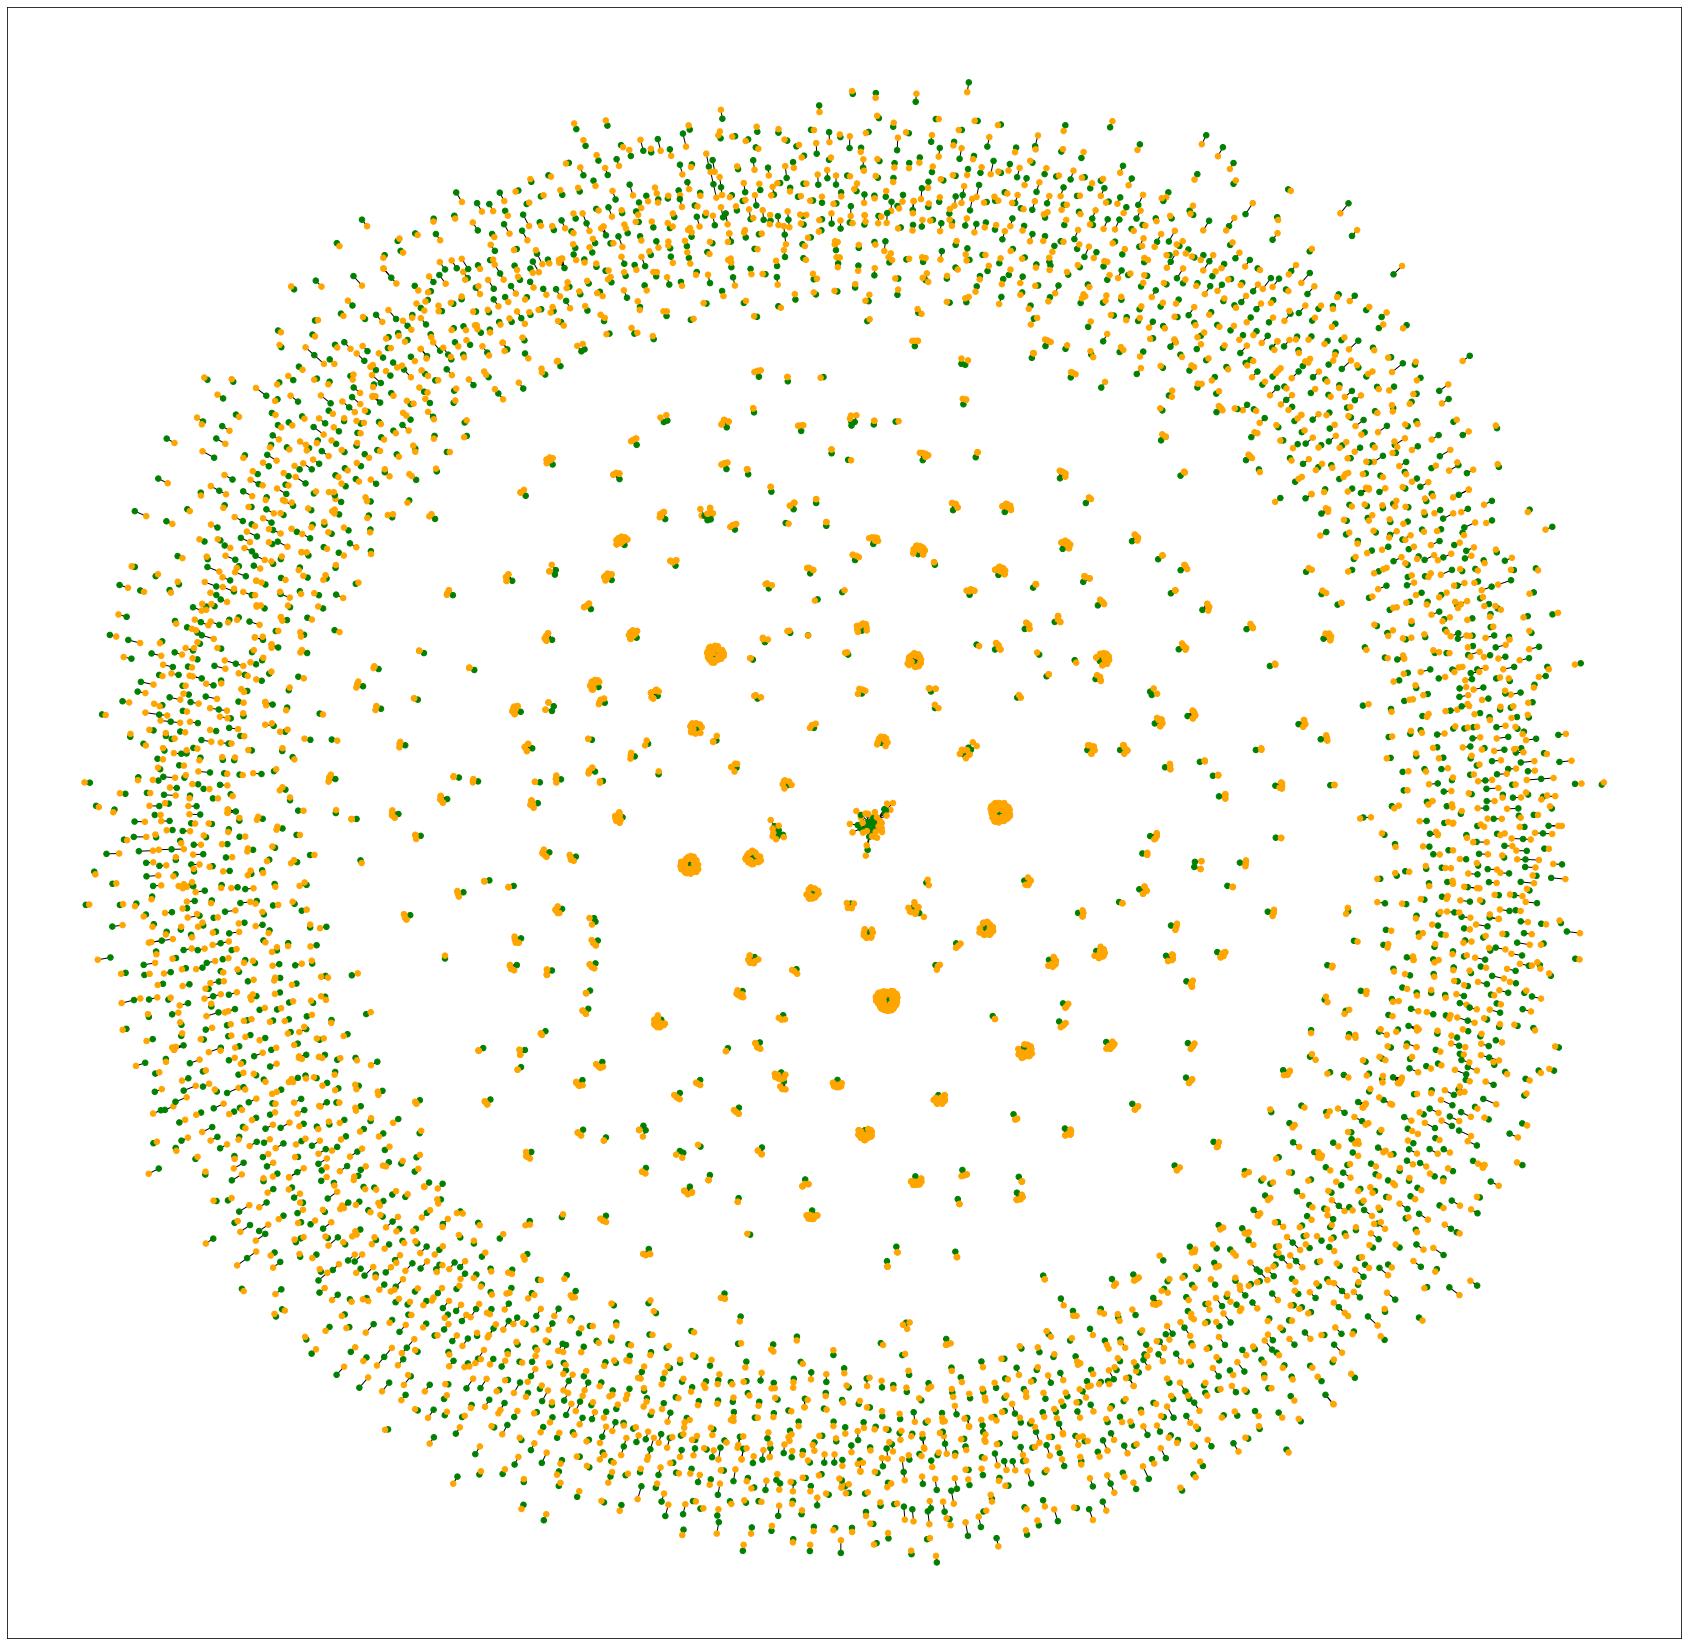

In [16]:
# Careful: very slow cell

import matplotlib.pyplot as plt
#import PyQt5
#%matplotlib qt

fig, ax = plt.subplots(figsize=(30,30))
nx.draw_networkx(g, with_labels=False, node_size=30, node_color=color_map)

### Ok. Quite artsy, but definitely useless

### I will now transform the network into a json file, then readable by the following script:

https://observablehq.com/@d3/disjoint-force-directed-graph
    
### this is one of the many amazing templates of D3js, a javascript library for data visualization

In [48]:
import json

nodes = [{'id': str(i), 'group': g.nodes[i]['color']}
         for i in g.nodes()]
links = [{'source': str(u[0]), 'target': str(u[1])}
         for u in g.edges()]
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links}, f, indent=4,)

### Try to replace the file of the Observablehq notebook with the .json you've just generated, to bring your network to life :-) 